In [1]:
import tensorflow as tf
import numpy as np
import PIL.Image

In [2]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [3]:
content_path = './images/yellowdog.jpg'
style_path = './images/startwinklenight.jpg'

In [4]:
def load_img(path_image):
    max_dim = 512
    img = tf.io.read_file(path_image)
    img = tf.image.decode_image(img, 3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape*scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [5]:
import matplotlib.pyplot as plt

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

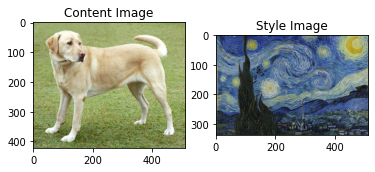

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [7]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*100)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [8]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.6886289),
 ('golden_retriever', 0.07500836),
 ('kuvasz', 0.042796347),
 ('Great_Pyrenees', 0.03253152),
 ('Chesapeake_Bay_retriever', 0.032177363)]

In [9]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
  print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [10]:
content_layers = ["block5_conv2"]
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
num_content_layer = len(content_layers)
num_style_layers = len(style_layers)

In [11]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [12]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("크기: ", output.numpy().shape)
  print("최솟값: ", output.numpy().min())
  print("최댓값: ", output.numpy().max())
  print("평균: ", output.numpy().mean())
  print()

block1_conv1
크기:  (1, 338, 511, 64)
최솟값:  0.0
최댓값:  643.2354
평균:  22.111395

block2_conv1
크기:  (1, 169, 255, 128)
최솟값:  0.0
최댓값:  2384.6443
평균:  132.71045

block3_conv1
크기:  (1, 84, 127, 256)
최솟값:  0.0
최댓값:  5926.893
평균:  127.345

block4_conv1
크기:  (1, 42, 63, 512)
최솟값:  0.0
최댓값:  15371.859
평균:  480.39017

block5_conv1
크기:  (1, 21, 31, 512)
최솟값:  0.0
최댓값:  3163.2515
평균:  39.5975



In [13]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [14]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers+content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        return {"content": content_dict, "style": style_dict}

In [15]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

print("style: ")
for name, output in sorted(results["style"].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("content: ")
for name, output in sorted(results["content"].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())

style: 
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.0055228462
    최댓값:  28014.557
    평균:  263.79022

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  61479.49
    평균:  9100.949

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0
    최댓값:  545623.44
    평균:  7660.9766

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  4320502.0
    평균:  134288.84

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  110005.38
    평균:  1487.0378

content: 
   block5_conv4
    크기:  (1, 26, 32, 512)
    최솟값:  0.0
    최댓값:  466.38382
    평균:  0.85768706


In [16]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

In [17]:
image = tf.Variable(content_image)

In [18]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_max=1.0, clip_value_min=0.0)

In [19]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [20]:
style_weight = 1e-2
content_weigt = 1e4

In [21]:
def style_content_loss(output):
    style_outputs = output["style"]
    content_outputs = output["content"]
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weigt / num_content_layer
    loss = style_loss + content_loss
    return loss

In [22]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

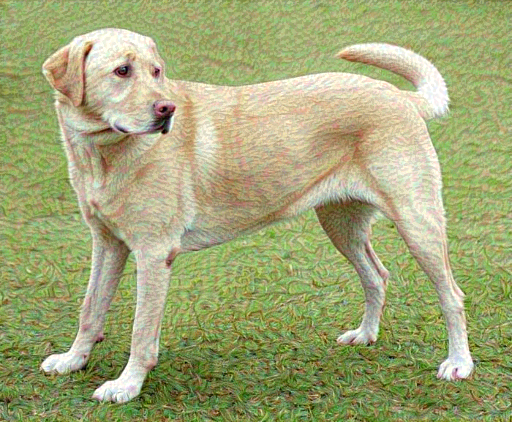

In [23]:
epochs = 3

for _ in range(epochs):
    train_step(image)

tensor_to_image(image)

In [24]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

....................................................................................................훈련 스텝: 100
....................................................................................................훈련 스텝: 200
....................................................................................................훈련 스텝: 300
....................................................................................................훈련 스텝: 400
....................................................................................................훈련 스텝: 500
....................................................................................................훈련 스텝: 600
....................................................................................................훈련 스텝: 700
....................................................................................................훈련 스텝: 800
....................................................................................................훈련 스텝: 900
.

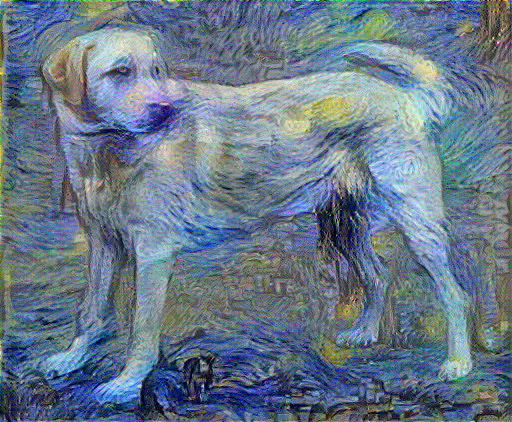

In [25]:
tensor_to_image(image)

In [26]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

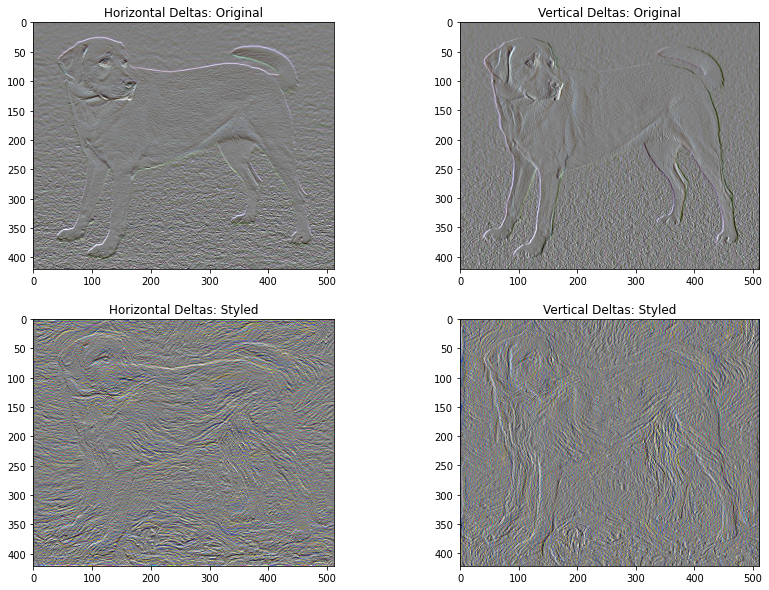

In [27]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

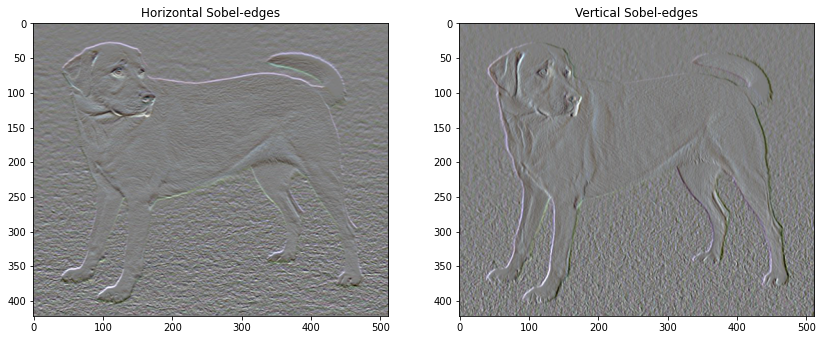

In [28]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [29]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [30]:
total_variation_loss(image).numpy()

108454.62

In [31]:
tf.image.total_variation(image).numpy()

array([108454.62], dtype=float32)

In [32]:
total_variation_weight = 30

In [33]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [34]:
image = tf.Variable(content_image)

....................................................................................................훈련 스텝: 100
....................................................................................................훈련 스텝: 200
....................................................................................................훈련 스텝: 300
....................................................................................................훈련 스텝: 400
....................................................................................................훈련 스텝: 500
....................................................................................................훈련 스텝: 600
....................................................................................................훈련 스텝: 700
....................................................................................................훈련 스텝: 800
....................................................................................................훈련 스텝: 900
.

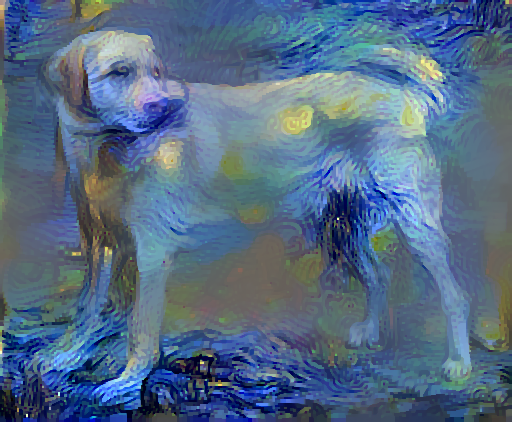

In [35]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

tensor_to_image(image)